<a href="https://colab.research.google.com/github/rpradata-ud/DSPS_RPradata/blob/main/HW/HW5/HW5_FitLineToGRBAfterGlow_mcmc_RPradata_DSPS23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods.

Notes:

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [1]:
import pandas as pd
import pylab as pl
%pylab inline

import numpy as np

from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize

from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


# Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [2]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/main/data/grb050525A.csv")
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


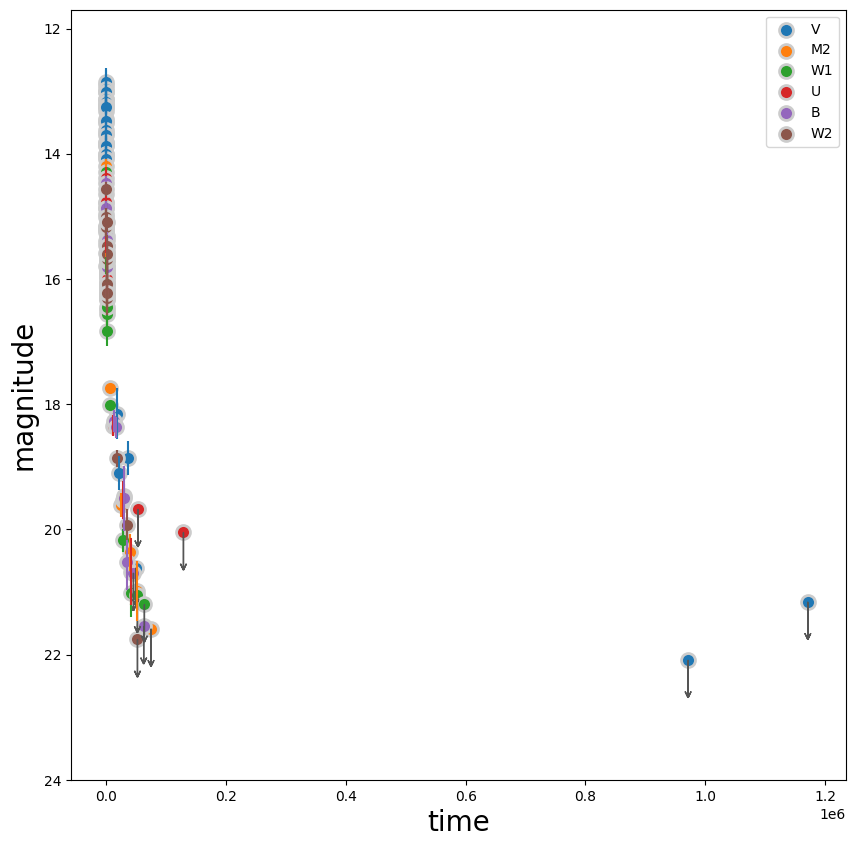

In [3]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].time,
             grbAG.loc[i].mag, 0, 0.5, head_width=1e4,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("time", fontsize=20);

Figure 1: A plot of time vs. magnitude of the GRB afterglow measurements. The "filters" of each measurement are indicated by colors described in the legend. The uncertainties are plotted by errorbars, and the upperlimit by arrows.

Notice that the y-axis (magnitude) increases downward. The shape of the scatterplot is indicative of a power law. Hence, this indicates that we are going to proceed with a logarithmic scaling in the time axis.

# Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [4]:
grbAG.head()

logtime = np.log10(grbAG['time'])

grbAG.insert(5, "logtime", logtime, True)

grbAG

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098
...,...,...,...,...,...,...
114,W1,63738,21.20,NaN,1,4.804398
115,M2,74798,21.59,NaN,1,4.873890
116,U,128928,20.05,NaN,1,5.110347
117,V,971360,22.09,NaN,1,5.987380


# Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B.

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

In [5]:
def plotlogtime(df, models=[]):
  #create a figure container and an axis object inside of it
  ax = pl.figure(figsize=(10,10)).add_subplot(111)

  #loop on every filter to plot - this will give differnt colors naturally.
  #Use pl.errorbar to plot the uncertainties

  for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

  # replot to add a better marker (optional)
  for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


  # plot the upperlimits as arrows
  nuplim = grbAG.mag.isna().sum()
  for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].mag, 0, 0.5, head_width=0.1,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  pl.ylim(24,11.7)
  pl.legend()

  #Always rememebr you axis labels!!
  pl.ylabel("magnitude", fontsize=20)
  pl.xlabel("log time", fontsize=20)
  return ax

<Axes: xlabel='log time', ylabel='magnitude'>

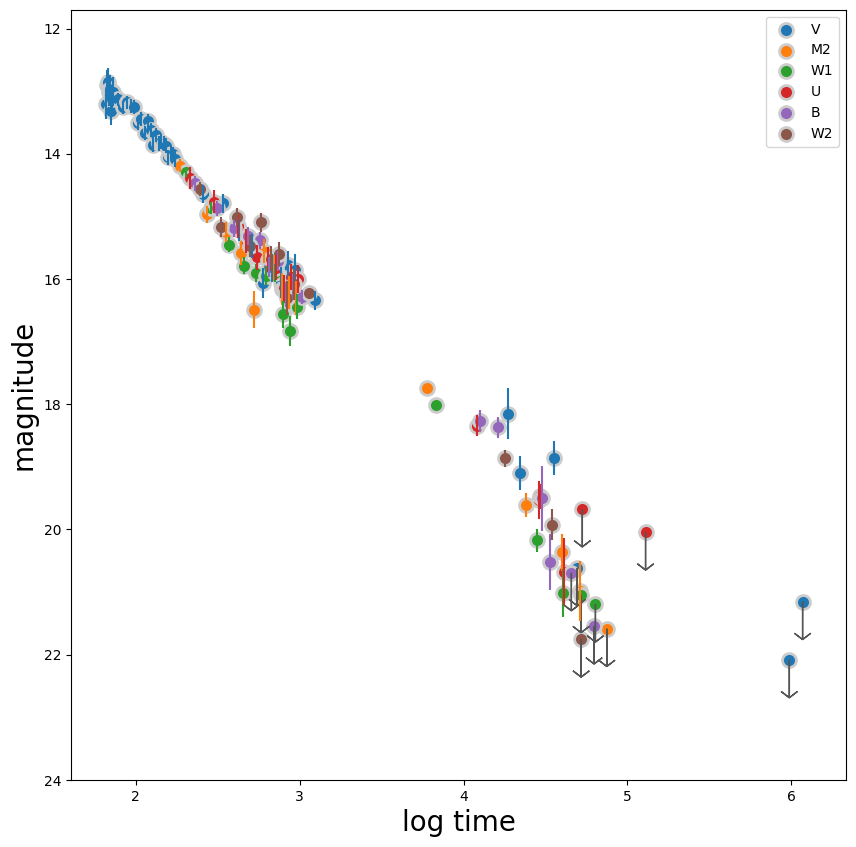

In [6]:
plotlogtime(grbAG)

Figure 2: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

Compared to Figure 1, the x-axis is now in log time here.

# Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [7]:
x = grbAG[grbAG.upperlimit == 0].logtime.values
X = np.c_[np.ones((len(grbAG) - grbAG.upperlimit.sum(), 1)),
          x]


y = grbAG.loc[grbAG.upperlimit == 0].mag.values
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [8]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " +
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


# Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```.
To remove the upper limits you can "broadcast" the data: in pandas that looks like

```grbAG.loc[grbAG.upperlimit == 0]```



In [9]:
grbAG = grbAG[grbAG['upperlimit']==0]

In [10]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
# from sklearn.linear_model import LinearRegression
lr = LinearRegression()


X = np.c_[np.ones(len(x)), x]
lr.fit(X, y)
lr.coef_, lr.intercept_

print("the best fit parameters from SKlearn are intercept: {0:.2f} slope: {1:.2f}".format(lr.intercept_, lr.coef_[1]))

the best fit parameters from SKlearn are intercept: 8.58 slope: 2.51


# Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 and L2 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [11]:
def line(intercept, slope, x):
    return intercept+ slope*x

In [12]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
# from scipy.optimize import minimize

# def line(intercept, slope, x):
#     ...
def l1(args, x, y):
  '''l1 target function: returns value of l1 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L1 sum of difference between prediction and data squared
    '''
  a, b = args
  L_1 = 0
  #the minimize fn is not going to take it unless it's a scalar array. therefore, use numpy.
  #^TypeError: only integer scalar arrays can be converted to a scalar index with 1D numpy indices array

  #see optimization slides. on Objective Function
  # for i in range(x):
    # L_1 += abs(f-y)
  L_1 = np.sum(np.absolute(y - line(x, a, b)))
    #can also use sum() function
  return L_1


initialGuess = (11, 1)

#what does the initialGuess look like?

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " +
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 103.31096922031703
        x: [ 9.997e+00  1.285e+00]
      nit: 5
      jac: [-9.537e-07 -9.537e-07]
 hess_inv: [[ 8.035e-02 -8.754e-03]
            [-8.754e-03  9.693e-04]]
     nfev: 33
     njev: 11

best fit parameters from the minimization of L1: slope 10.00, intercept 1.29


In [13]:

def l2(args, x, y):
    '''l2 target function: returns value of l2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L2 sum of difference between prediction and data squared
    '''
    a, b = args
  # L_2 = 0
  # for i in range(x):
    L_2 = np.sum((y - line(x, a, b))**2)
    return L_2


initialGuess = (11, 1)

l2Solution = minimize(l2, initialGuess, args=(x, y))
print(l2Solution)
print("")
print("best fit parameters from the minimization of L2: " +
       "slope {:.2f}, intercept {:.2f}".format(*l2Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 173.5155808208851
        x: [ 1.108e+01  1.164e+00]
      nit: 7
      jac: [-1.717e-05  3.815e-06]
 hess_inv: [[ 4.634e-05 -4.632e-05]
            [-4.632e-05  4.632e-05]]
     nfev: 164
     njev: 51

best fit parameters from the minimization of L2: slope 11.08, intercept 1.16


#come back to check where to use line in the objective functions

In [14]:
l2?


# Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [15]:
theta_best

array([8.58266823, 2.51199984])

In [16]:
def chi2(args, x, y, s):
  '''chi2 target function: returns value of l2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    s: the uncertainty values of y (array)
    returns chi2 sum of difference between prediction and data squared
    '''
  a, b = args
  chi2 = np.sum(((y - line(x, a, b))**2)/s**2)
  return chi2

x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values

initialGuess = (11,1)

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " +
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 5748.326081665081
        x: [ 1.109e+01  1.135e+00]
      nit: 13
      jac: [-1.221e-04  6.226e-03]
 hess_inv: [[ 1.646e-08 -2.365e-09]
            [-2.365e-09  8.184e-07]]
     nfev: 192
     njev: 60

best fit parameters from the minimization of the chi squared: slope 11.09, intercept 1.13


Notes: keep trying the initialGuess values until you get the right curve.

# Plot all the solutions

Create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.


In [17]:
theta_best

array([8.58266823, 2.51199984])

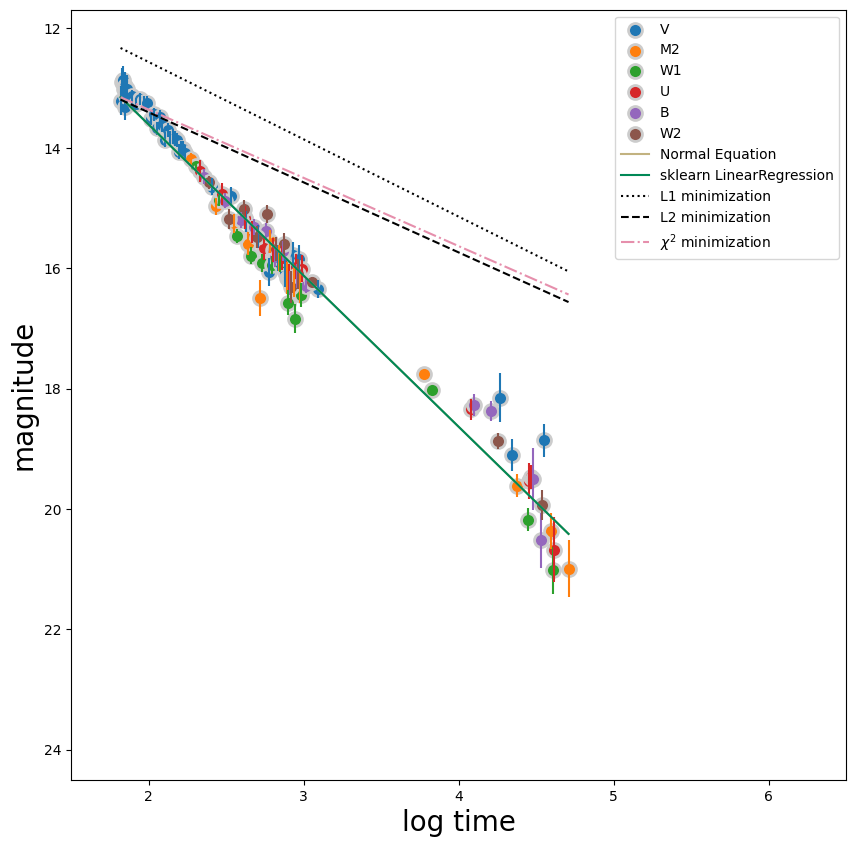

In [18]:
def plotline(pars, x, color='k', symbol='-', label='model',
             alpha=1, ax=ax):
    slope, intercept = pars
    y = line(intercept, slope, x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((theta_best[1], theta_best[0]), grbAG.logtime.values,
         color='#'+colors[0],
         label="Normal Equation", ax=ax)

#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--',
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);


Figure 3: Photometry of the GRB afterglow, plotted as magnitude vs. log time, as with the previous figure (but excluding upper limits). Here, the line fits, computed with the Normal equation, sklearn LinearRegression, as well as the objective function minimizations, are also plotted, described in the legend.


So far, it seems that the sklearn curve and the Normal Equation solution give the best fit out of the 5 models (these two have the same slope and intercept values).

# HW part 1: redo the sklearn model with a train-test split of the data

- choose the train-test rations that you prefer
- get the score for the model when predicting on the train data and on the test data
- what can you say about the model by comparing the two scores?

In [19]:
# from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.25, random_state=42)

reg = LinearRegression()
fit = reg.fit(X_train, y_train)
score_train = fit.score(X_train, y_train)

fit = reg.fit(X_test, y_test)
score_test = fit.score(X_test, y_test)

print("Applying reg.score()")
print("Reg score on training: ", score_train)
print("Reg score on test: ", score_test)

Applying reg.score()
Reg score on training:  0.9716992501494651
Reg score on test:  0.9742710333378128


By splitting the model to 75% training data and 25% test data in the sklearn model, we have predictions that are high in accuracy. For both train and test, we have reg score (R^2 score) above 0.97. Therefore, the model fits the scatterplots very well. Moreover, the score for the test data is slightly higher than that of the train data, which indicates that the model tends to follow closer to it, at 25% of the entire data ration.

# Now try a line to the data with MCMC

# HW part 2: write captions for each figure. The figures are produced by my code. The captions should state:
- what is plotted
- what is noticeable or interesting in the figure



In [21]:
!pip install emcee # install the emcee package that implements the _affine invariant MCMC_ method

In [22]:
import emcee #import the package

In [23]:
emcee

<module 'emcee' from '/usr/local/lib/python3.10/dist-packages/emcee/__init__.py'>

look at documentation: https://emcee.readthedocs.io/en/stable/

We are implementing Bayes theorem to find the best model parameters: $P(\theta | D) ~ P(D | \theta) * P(\theta)$ or _Posterior ~ Likelihood * Prior_

Since we are maximizing the likelihood, we work in log space because:
- the logarithm is a monotonic function of its argument (meaning where the argument gets bigger its log gets bigger, where it gets smaller its log gets smaller)
- the log is not defined for negative values (log(something < 0) is undefined) but this does not matter because the likelihood is a probability and probabilities are positive defined.



In [24]:
# LINE MODEL
def log_prior(theta):
  slope, intercept = theta
  if slope > 0 and intercept > 0:
    return 0
  #semi informative prior: i know light has to get fainter (mag get bigger)
  #i know i dont use negative mags
  return -np.inf




note to self:
if the values are larger than 0 (good), then log_prior = 0. it means the prior is 1.
(meaning behind prior? and prior being = 1?)

p(theta) is the probability of theta being true. This is the knowledge.

so it makes sense that, because we only want positive slope and positive intercept, that the probability of getting that certain value is true
and the value otherwise would lead to a prior / probability very close to 0, hence approaching log -inf.

**btw, it will be positive because remember we inverted the magnitude so that higher magnitude means brighter.

In [25]:
#log likelihood
def log_likelihood(theta, x, y, yerr):
  slope, intercept = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2

  return -np.sum(((y - line(intercept, slope, x))**2) / yerr**2)

for likelihood: probability of D being true given theta is true. p(D|theta)


In [26]:
#log posterior
def log_posterior(theta, x, y, yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp + log_likelihood(theta, x, y, yerr)

want to maximize likelihood.
hence minimize negative log likelihood

In [27]:
#initial guess
ig = [1,10]

In [28]:
#initialize N walkers
nwalkers = 32
ndim = len(ig)

In [29]:
np.random.randn?

In [30]:
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)

the starting point for each walker is a small perturbation of the initial guess.

note: ndim is len. of ig (is 2; 2 columns).
so dimension of pos is (starting point of each walker): nwalkers (32) x ndim (2)

In [31]:
pos.shape

(32, 2)

In [32]:
# this sets up the model and assignes the hyperparameters
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, s))

In [33]:
emcee.EnsembleSampler?

In [34]:
# pos
# ndim
# len(pos)

sampler; EnsembleSampler from emcee

In [35]:
# this runs the MCMC for 5,000 steps
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:15<00:00, 328.16it/s]


In [36]:
# this extracts the ergodic markovian chains of positions in the feature space
samples = sampler.get_chain()

"The samples can be accessed using the EnsembleSampler.get_chain() method. This will return an array with the shape (no. of runs, nwalkers, ndim) giving the parameter values for each walker at each step in the chain. "

https://emcee.readthedocs.io/en/stable/tutorials/quickstart/#quickstart

In [37]:
samples.shape


(5000, 32, 2)

In [38]:
# samples

In [39]:
# to get statistical properties of the chains I will concatenate (putting the all together in one dataset) the 32 chains. This works _iff_ the chains are independent
# note: the chains are _assumed_ to be independent

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)





note to self: the samples are broken up into nwalker (32); and so we "flatten" them to have them all in one space.

For "flat_samples" on which ones to discard, make sure we look at the full plot first before deciding it. e.g.: in ours, we see the full graph and see that we want to discard the 1st 100 points

In [40]:
# sampler.get_chain?

flat_samples.shape

(10432, 2)

In [41]:
#the result of the mcmc (the best parameters and their uncertainties) are statistical properties of the chains
# I recommand the median and percentiles over the mean and standard deviation, since the chains need not be gaussian
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
mcmc

#why do we want the 16th, 50th, and 84th percentile though?
#so ok, mcmc has 3 columns; each corresponding to the 3 percentile values.
#and then it runs down through i of range(ndim) (#of rows of mcmc)

array([[2.46596519, 2.47995261, 2.49430267],
       [8.56046169, 8.60023989, 8.63911744]])

In [42]:
#note to self:
p = np.percentile([1,2,3], [30, 50])

#^this basically says that given the dataset a (on the left),
#we compute the ith percentile, based on the i values in q (on the right).

flat_samples

array([[2.4697021 , 8.64600466],
       [2.49112726, 8.5627009 ],
       [2.37513006, 8.8469928 ],
       ...,
       [2.4823933 , 8.59519243],
       [2.46317573, 8.64688398],
       [2.49050044, 8.56802088]])

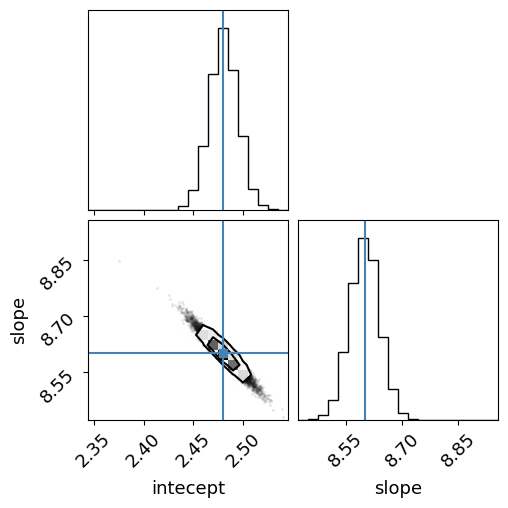

In [43]:
#plotting the likelihood space: the panels are 2D projections of the feature space and 1D marginalized probabilities for each parameters
!pip install corner
import corner
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["intecept", "slope"], truths=mcmc[:,1]);


Figure 4:  Panels showing 2D projections of the feature space and the 1D marginalized probabilities of each parameter. These describe the process of predicting the GRB line fit slope and intercept, based on the MCMC model.

The way I read this is:
The contour graph in the middle has a point that is most "densely" shaded, which is marked by the intersection between blue lines. A way to interpret this is that, this is where the walker visits most. Hence, in general, the darker the shade of the contour, the more the walker visits that area.

If we see this contour graph as a "2D mountain", the panels to its right and above it respectively show the "side views" of the most likely value predicted for each parameter.

Moreover, the contour graph shows a thin "elliptical" shape, which describes correlation between the two parameters. There seems to be a negative correlation in this case, in which as we follow the contours and increase our intercept value, we would decrease the slope value.

In [44]:
samples.shape

samples[0], samples.shape, sampler

#^this prints for one of the 5000 runs. has 32 rows, 2 columns (2 dimensions (len of the initial guess))
#samples was the get_chain() for the sampler. it shows the parameter values for each walker at each step in the chain.

(array([[ 1.00015614,  9.99988778],
        [ 1.00000287, 10.00012848],
        [ 0.99993175, 10.00023405],
        [ 0.99994763, 10.00008499],
        [ 0.99996401, 10.00016701],
        [ 0.99989138, 10.00010624],
        [ 1.00003338, 10.00000548],
        [ 0.99999507, 10.00000393],
        [ 1.00009001,  9.99988542],
        [ 0.99996825, 10.00011231],
        [ 0.99993657,  9.99996047],
        [ 0.99990902,  9.99994019],
        [ 1.00013902,  9.99996369],
        [ 0.99995682, 10.00004235],
        [ 0.99999801, 10.00001501],
        [ 0.99992077,  9.99982569],
        [ 1.00005345, 10.00006341],
        [ 0.99994474, 10.0001503 ],
        [ 0.99990745,  9.9999944 ],
        [ 1.00000462, 10.00003453],
        [ 0.99991078, 10.00020368],
        [ 0.99989669,  9.99990254],
        [ 0.9999324 ,  9.99997053],
        [ 1.00004247,  9.99982487],
        [ 0.99992395, 10.00008727],
        [ 0.99991476, 10.00007038],
        [ 1.00023482, 10.00018914],
        [ 0.99999238, 10.000

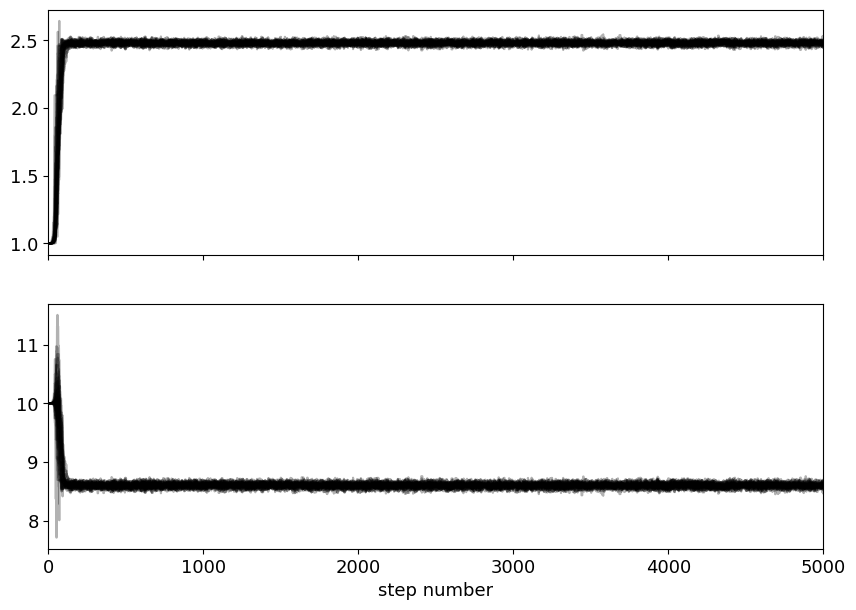

In [45]:
# the chains should be plotted as well. in the slides and in class I discuss what you should expect them to look like
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Figure 5: The plotted chains from the MCMC model (run for 5000 steps) for the intercept (top panel) and the slope (bottom panel). The value in the intercept seems to strongly converge at around 2.5, and that of the slope strongly converges around 8.6, which is as expected as we compare to our plot in Figure 4. Though, there is a "burn-in" period at around the first 100 steps, where the chain still "warms up". This would usually be discarded in order to approximate the parameter distribution.

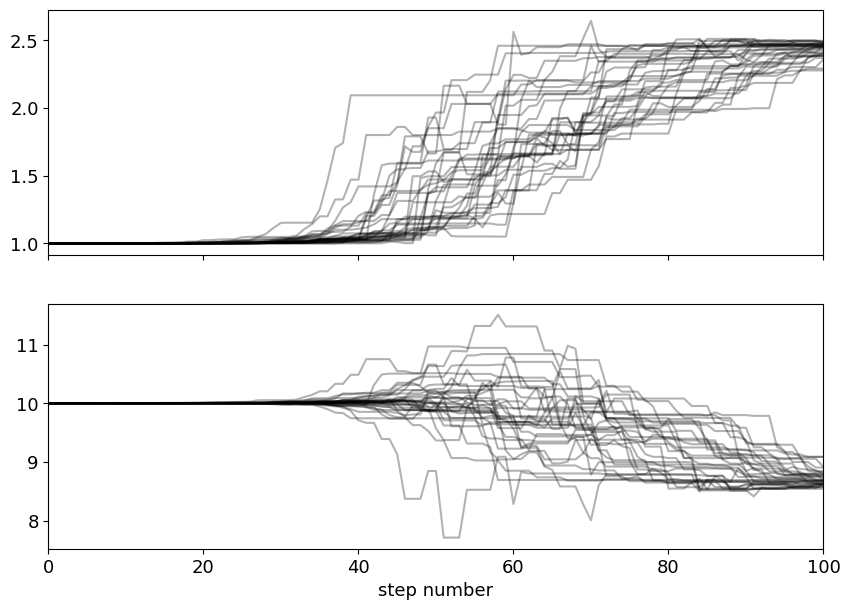

In [46]:
# zoom in: the beginnign of the chane should be cut - this is the burn-in part of the chain
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Figure 6: A zoom-in to the burn-in period of the chain. As described previously, we usually would want to discard this part to compute the parameter distribution.

Though, here we can see more clearly that the chain starts at the initial guess [1, 10] which shows how crucial this value is.

In [47]:
# save the mcmc results for later
mcmc_line = mcmc

# HW part 3

# Now try a broken power law (BPL) model

A power la is not a good model for GRB afterglows. A broken power law has been known to be a better model and has several physical motivations. In this exercise you will fit a _broke power law_ to the data, which is a more complex and higher dimensional model than the simple line fit we did so far, with MCMC getting best values for the posterior, a complete characterization of the likelihood, and allowing model selection between the line and the power law.

> Here is some info that talks about the power law model and the phsyics of GRB, which you need not know to solve the assignment but you may be interested in.  A broken power law is a power law ($y ~ x^a$) where the power a changes at some point. This can be caused by the presence of two power law processes with different, for example, where one dominates at early time and the other at late times.


>> Here is some more info that explains why we observed the GRB afterglows as broken power laws.
>>Gamma-ray bursts (GRBs) are produced by the collapse of massive stars or the merger of compact objects like neutron stars. The energy of the collapse is highly energetic (Gamma rays) but the emission gets reprocessed as it leaves the system and looses energy becoming detectable in the optical wavelengths. This is called the "optical afterglow of the GRB".
>>The explosion resulting from the collapse generates a highly relativistic outflow of material that moves at a significant fraction of the speed of light.
>> The afterglow emission is primarily produced through synchrotron radiation, where charged particles spiral around magnetic field lines. The radiation produced by synchrotrone follows a power law with an index that depends on the density of the surrounding medium, the Lorentz factor of the outflow, and the magnetic field strength. As the radiation crosses different regions of the system that collapsed these factors change and the powerlaw index changes with them.

>>If the relativistic outflow is highly collimated (a jet) as the jet expands, its emission can be modeled as a power-law light curve, but  where the jet begins to decelerate and spread out the slope of the power law changes. This transition is known as the "jet break" and results in a broken power-law behavior.

>> Some GRBs exhibit late-time flares or additional energy injection from the central engine but we are not modeling this in this exercise.




_BPL model variables:_

$F = \mathrm{flux}$ - note: not magnitude this time! $mag ~ -2.5log10(Flux)$

$t =  \mathrm{time}$ - note: not log time

_BPL model parameters:_


$T_b =  \mathrm{Time~of~break}$

$a_1:  \mathrm{Early~slope}$

$a_2: \mathrm{Late~slope}$

$b:  \mathrm{nuisance~parameters}$

_BPL model_:

in flux space the BPL model is:
$F=\frac{F_0}{ \frac{t}{T_b}^{-a1} + \frac{t}{T_b}^{-a2}}$

in magnitude space (the data you want to predict is in magnitude and the equation is simple to minimize in log space) that is:

$mag = b - log_{10}\left((\frac{t}{T_b})^{-a1} + (\frac{t}{T_b})^{-a2})\right) $



In [48]:
t = grbAG[grbAG.upperlimit == 0].time.values

In [49]:
t.min(), t.max()

(66, 51257)

# HW part 3 task 1:
create the model `bpl()`, the `log_likelihood()`, `log_prior()` (choose what you want to set your prior to), and `log_posterior()`

In [50]:
def bpl(theta, x):
    """broken power law model
    Input:
      theta: (array like) 4 parameters vector, see equation
      x: (array like) independent variable
    Return:
      model predictions for each x
    """


    b, T_b, a1, a2 = theta
    #independent variable is x

    mag = b - np.log10((x/T_b)**(-a1)+(x/T_b)**(-a2))

    return mag


In [51]:
def log_likelihood_bpl(theta, x, y, yerr):

    """log likelihood of the broken power law model
    Input:
      theta: (array like) 4 parameters vector, see equation
      x: (array like) independent variable
      y: (array like) variable that is to be plotted against x
      yerr: (array like) uncertainty values for the variable specified as y
    Return:
      log likelihood value of the bpl model, with chi2

    """
    return np.sum(((y - bpl(theta, x))**2) / yerr**2)
    # use the same log_likelihood as before (chi2) but with the new model

  #chi2 likelihood : (data-model)**2 / uncertainty **2

  # inputs were theta, x, y, yerr

  #here, inputs would be y, yerr, theta.
  #then we would use bpl(theta, x)
  #so, the inputs would be: x, y, yerr, theta

  #instead of slope, intercept - theta, we have the theta (with 4 parameters) for bpl



def log_prior_bpl(theta):

  """log prior of the bpl model
    Input:
      theta: (array like) 4 parameters vector, see equation

    Return:
      logarithm prior value of input theta
    """

  # slope, intercept = theta
  # if slope > 0 and intercept > 0:
  #   return 0
  # #semi informative prior: i know light has to get fainter (mag get bigger)
  # #i know i dont use negative mags
  # return -np.inf
  b, T_b, a1, a2 = theta
  if T_b > 0 and a1 > 0 and a2 >0:
    return 0
  return -np.inf

def log_posterior_bpl(theta, x, y, yerr):

  """log posterior of the bpl model
    Input:
      theta: (array like) 4 parameters vector, see equation
      y: (array like) variable that is to be plotted against x
      yerr: (array like) uncertainty values for the variable specified as y

    Return:
      logarithm posterior value of the bpl model
    """
  lp = log_prior_bpl(theta)
  ll = log_likelihood_bpl(theta, x, y, yerr)

  if not np.isfinite(lp):
    return -np.inf
  return lp - ll

#there was an error (invalid value-related). turned out my mag for bpl was a bit wrong. i initially had np.log; but i needed to have np.log10 instead.
#Also, my log_likelihood_bpl was coming out with an error.
#i initially had -np.sum. but in the function, Masooma suggested (from Willow) to get rid of the negative sign in that function,
#and instead incorporate it in the log_posterior_bpl function instead. from lp + ll,
#so we changed it to lp - ll.
#For the likelihood probability, Sarah suggested on giving bounds of a1 and a2 so they wouldn't give out wacky values.



# HW part 3 task 2:
Find the initial starting point as a stochastic gradient descent minimization of the log likelihood

In [52]:

ig = [0.2, 1000, 5, 20]

#note to self: need to match the values of the initial guesses, with theta parameters


#what does the minimize function need to take as arguments?
soln = minimize(log_likelihood_bpl, ig, args=(t, y, s))


soln.x

print("best fit parameters from the minimization of the (chi2) BPL line: " +
       "b: {:.2f}, Tb: {:.2f}, a1: {:.2f}, a2: {:.2f}".format(*soln.x))


#Miles helped me understand this; I was caught up / worried about which chi2 function.
#i knew we needed to use the log_likelihood_bpl which has the 4 parameters in theta
#but then worried about how to put theta in the args. but realized by context with the previous chi2 example
#with initialGuess (m,v), that we didn't need to explicitly put it in the args.



best fit parameters from the minimization of the (chi2) BPL line: b: 15.05, Tb: 273.59, a1: 3.55, a2: 2.15


In [53]:
grbAG

x_nolog = grbAG[grbAG.upperlimit == 0].time.values

x_nolog

array([   66,    67,    68,    69,    70,    71,    72,    73,    78,
          83,    88,    93,    98,   103,   108,   113,   118,   123,
         128,   133,   138,   143,   148,   153,   158,   163,   168,
         173,   187,   202,   215,   229,   245,   258,   272,   286,
         299,   313,   329,   342,   356,   370,   397,   413,   419,
         426,   440,   455,   468,   482,   498,   511,   525,   539,
         552,   571,   582,   595,   609,   624,   637,   651,   666,
         680,   694,   708,   721,   735,   751,   764,   778,   792,
         805,   820,   835,   849,   863,   877,   890,   904,   920,
         933,   947,   961,   975,  1034,  1140,  1243,  5984,  6761,
       12019, 12671, 16182, 17973, 18575, 22163, 24007, 28111, 28664,
       29380, 30031, 33898, 34806, 35638, 39683, 40585, 41040, 51257])

Text(0, 0.5, 'magnitude')

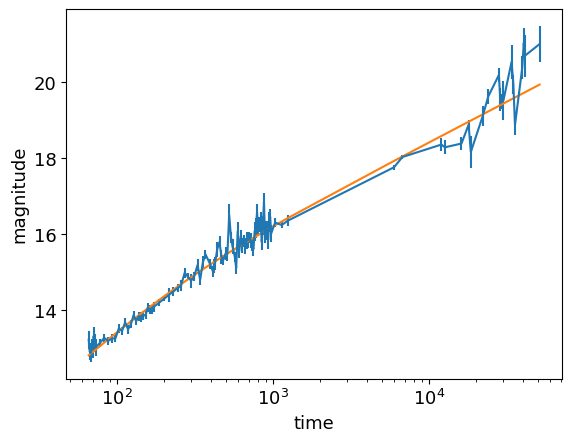

In [54]:
ig = soln.x # the initial guess for the MCMC

# plot the model as it looks with the initial guess values
pl.errorbar(x_nolog, y, yerr=s)
pl.plot(x_nolog, bpl(ig, t))
pl.xscale("log")

pl.xlabel("time")
pl.ylabel("magnitude")


Figure 7: A plot of the GRB magnitude vs. time measurements from the data (in blue), and the broken power law model from the function (in orange).

From the figure, it does seem that the broken power law fits the data pretty well.

# HW 3 task 3: optimize the model wit MCMC

- set the emcee hyperparameters
- run the chains
- extract the statistical properties of the chain as the best fit values
- plot the model
- plot the marginalized posteriors of the model parameters

In [55]:
ig

array([ 15.04718174, 273.58952203,   3.54796299,   2.14569351])

In [56]:
# set the emcee hyperparameters

nwalkers, ndim = 30, len(ig)
pos = np.array(ig) +1e-4 * np.random.randn(nwalkers, ndim)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_bpl, args=(t, y, s))

pos.shape

(30, 4)

In [57]:
# run the model
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_bpl, args=(t,y,s))

In [58]:
sampler.run_mcmc(pos, 5000, progress = True);

 11%|█         | 539/5000 [00:02<00:18, 245.73it/s]<ipython-input-50-52a38351d877>:14: RuntimeWarning: invalid value encountered in power
  mag = b - np.log10((x/T_b)**(-a1)+(x/T_b)**(-a2))
100%|██████████| 5000/5000 [00:26<00:00, 187.59it/s]


In [59]:
# samples = sampler.get_chain()

In [60]:
# samples.shape

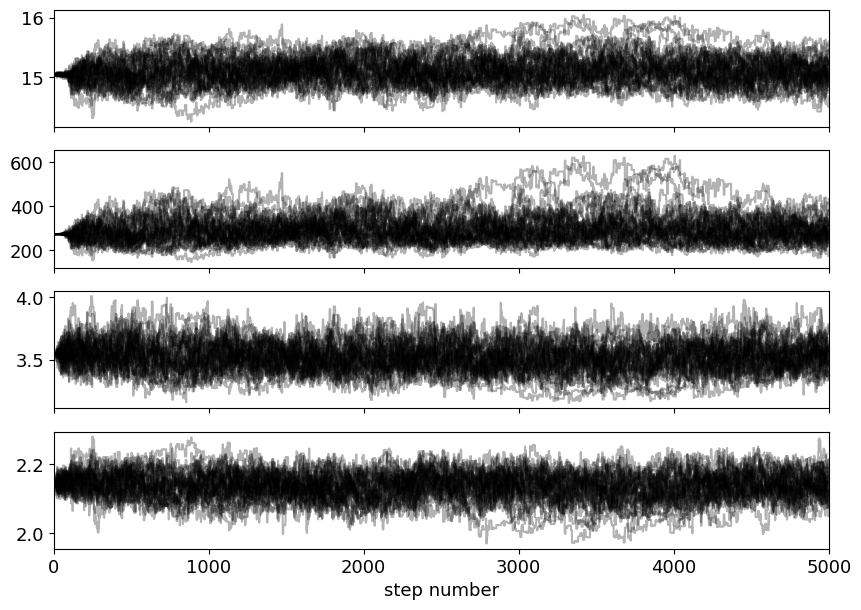

In [61]:
#plot the chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha = 0.3)
    ax.set_xlim(0, len(samples))
ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Figure 8: The plotted chains from the MCMC with BPL model (run for 5000 steps). From top to bottom are the chains for b (nuisance parameter), T_b (time of break), a1 (early slope), a2 (late slope). These plots show where the walkers go based on the algorithm. Compared to Figure 5, the distribution values here fluctuate over a range of values for each panel, throughout the MCMC run, instead of more sharply converge to a value.


In [62]:
# get the 16th, 50, and 84th percentiles of the model parameters
flat_samples = sampler.get_chain(discard = 100, thin = 15, flat = True)
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
    mcmc[i] = np.percentile(flat_samples[:,i], [16, 50, 84])
mcmc[:,1]

mcmc

#this prints the theta parameters [Tb, a1, a2, b] as a row each
#and each column shows the percentile

#for the graph, we only want to show the breakpoint Tb at the 50th percentile

#Masooma helped me understand this

array([[ 14.87045586,  15.09835937,  15.35786997],
       [237.04581926, 285.50267983, 354.79465033],
       [  3.40263555,   3.51935656,   3.64363734],
       [  2.09468531,   2.13809898,   2.17639142]])

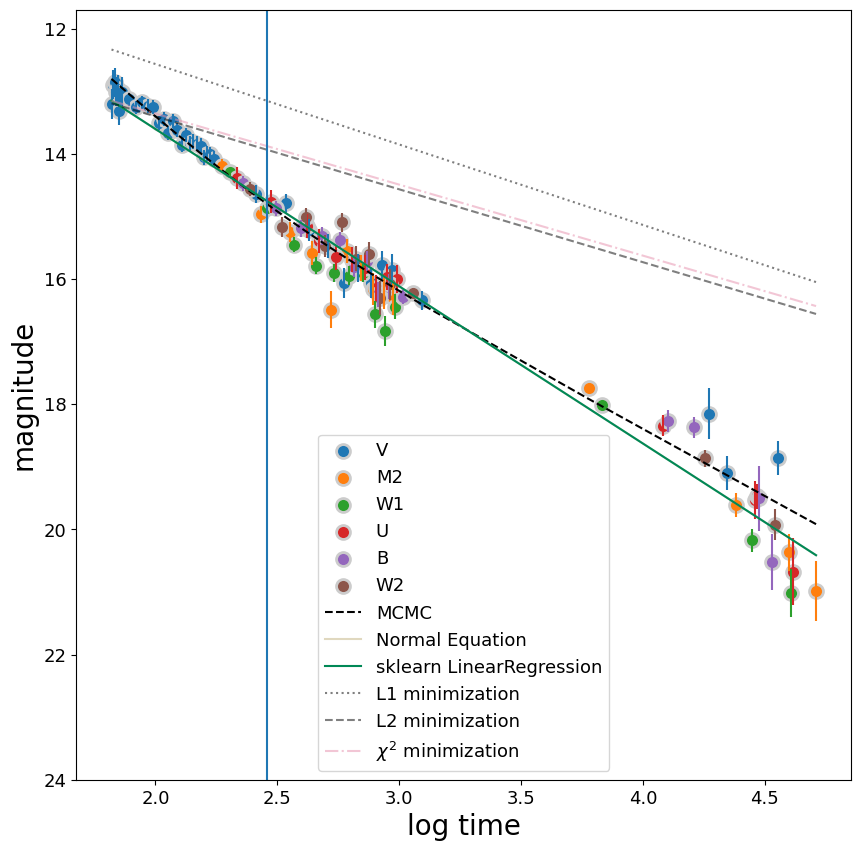

In [63]:
#plot the model
ax = plotlogtime(grbAG)

#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(grbAG.logtime.values, bpl(mcmc[:,1],
                            t), ls="--", c="k", label="MCMC")

# plotline((t), bpl(mcmc[:,1],grbAG.logtime.values),
#          color='#'+colors[0],  alpha=0.5,
#          label="Normal Equation", ax=ax)

#normal equation
plotline((theta_best[1], theta_best[0]), grbAG.logtime.values,
         color='#'+colors[0],  alpha=0.5,
         label="Normal Equation", ax=ax)
#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)
#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':', alpha=0.5,
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--', alpha=0.5,
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.', alpha=0.5,
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')
pl.axvline(np.log10(mcmc[1,1]))
# pl.ylim(24.5,11.7)
# pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);


#My MCMC graph wasn't showing. Masooma helped me edit the mcmc plot; initially the function was line() but we need bpl() so we made that change.
#and adjusted the func input accordingly

#then, also in plotting the vertical line. i was confused what it was, but then they explained that it was the point when Tb break
#so I had to change the mcmc indexing in the plot. from mcmc[k, 1], become mcmc[0,1] in my code bc theta was indexed as Tb, a1, a2, b. so Tb is row index 0
#and the 50th percentile is index column 1.

Figure 9: Same as in Figure 3, but with the MCMC-modeled fit line with the broken power law model (labelled "MCMC" in the legend), as well as the time of break at the 50th percentile, shown as the vertical straight blue line right before x = 2.5.

The MCMC-modeled line seems to follow the scatterplot closely, similar to the LinearRegression and Normal Equation solutions, yet it started deviate after around x = 3.25.

## plot the marginalized posterior distributions of the parameters

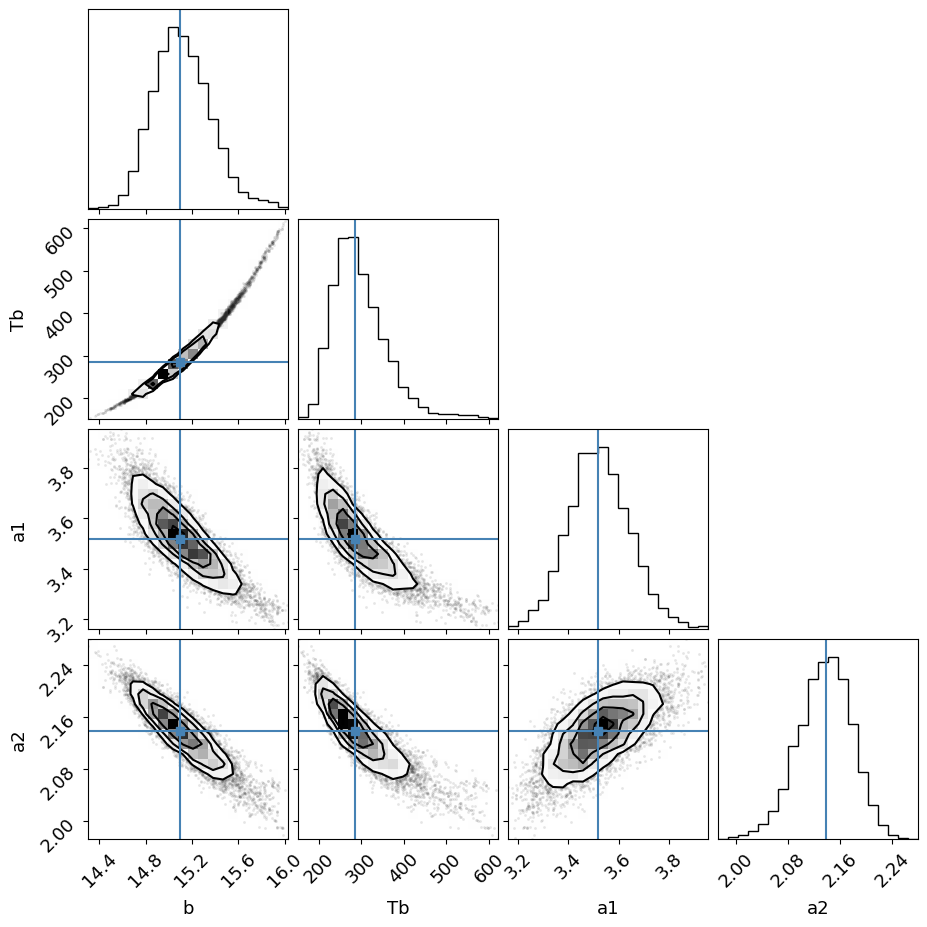

In [64]:

pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["b", "Tb", "a1", "a2"], truths=mcmc[:,1]);



Figure 10: The feature space projections and marginalized probability graphs for the parameters, as in Fig. 4, but for the MCMC-BPL model. Each contour panel shows correlation between the parameters; a1-b, a1-Tb, a2-b, and a2-Tb have negative correlation, while a1-a2 and Tb-b have positive correlation. The lattermost seems to also have the strongest correlation.

# HW part 4: Compare the line (as obtained by the MCMC) and broken power law models. For this part of the assignment use the slides in part 2.2 of the current slide deck (slide column 8) https://slides.com/federicabianco/dsps_6#/8. in particular:

- Print the loglikelihood of each model (you can use the log_likelihood function you had written for each)
https://slides.com/federicabianco/dsps_6#/8/1 through https://slides.com/federicabianco/dsps_6#/8/3

- implement the caluculation of the AIC (https://slides.com/federicabianco/dsps_6#/8/4 through 6)
- and BIC (https://slides.com/federicabianco/dsps_6#/8/7)



In [65]:
likelihood_linear = np.abs(log_likelihood(mcmc_line[:,1], x, y, s))

likelihood_bpl = np.abs(log_likelihood_bpl(mcmc[:,1], t, y, s))


In [66]:
print("log likelihood of the line MCMC model: {:.3f}".format(likelihood_linear)) #control the decimal digits!

log likelihood of the line MCMC model: 317.421


In [67]:
print("log likelihood of the broken power law MCMC model: {:.3f}".format(likelihood_bpl))

log likelihood of the broken power law MCMC model: 217.496


## Implement the likelihood ration test printing out the likelihood ration statistics

The likelihood-ratio test assesses the goodness of fit of two competing _nested_ statistical models based on the values of the likelihood $L$ where $M1$ is the restricted model (the parameter space is smaller, hence restricted), nested inside $M2$, the full model (the more complex one).

$ \lambda_\mathrm{LR}=-2\ln {\frac {L(M1(\theta_\mathrm{restricted}))}{L(M2(\theta_\mathrm{full}))}}$

This statistics is expexted to be $\chi2$ distributed following a $ch2$ distribution with d.o.f=difference in size of the parameter space in the two models (number of parameters in bpl model - number of parameters in line model).


For this ratio test, the null hypothesis is that the linear model (simpler) fits the data better than the BPL model (more complicated), and I set the p-threshold value to be 0.05 (alpha = 2-sigma).

In [68]:
k_linear = 2
k_bpl = 4

N_bpl = 1

N_linear = 1

In [69]:
# Likelihood ratio test
lambda_LR = -2 * np.log(likelihood_bpl / likelihood_linear)
# print(lambda_LR)

dof = k_bpl - k_linear

from scipy.stats.distributions import chi2
p = chi2.sf(lambda_LR, dof)
# print(p)

print("Lambda LR value = {:.3f}".format(lambda_LR))
print("As the statistic follows a chi-squared distribution, the p-value is computed to be {:.3f}".format(p))

Lambda LR value = 0.756
As the statistic follows a chi-squared distribution, the p-value is computed to be 0.685


The p-value computed for the Lambda LR is larger than the threshold, hence we cannot reject the null hypothesis. Therefore, based on this test, the linear MCMC model does fit the GRB data better than does the BPL MCMC model.

## Calculate the AIC and BIC: Aikiki Information Criterion and Bayesian Information Criterion for the comparison of the same two models.


In [70]:
# AIC test
N_linear = 1
AIC_linear = (-2 / N_linear) * np.log(likelihood_linear) + (2 / N_linear) * k_linear

N_bpl = 1
AIC_bpl = (-2 / N_bpl) * np.log(likelihood_bpl) + (2 / N_bpl) * k_bpl

AIC_linear, AIC_bpl

(-7.520457141567855, -2.7643623733238307)

In [71]:
# BIC test
BIC_linear = -2 * np.log(likelihood_linear) + np.log(N_linear) * k_linear

BIC_bpl = -2 * np.log(likelihood_bpl) + np.log(N_bpl) * k_bpl

BIC_linear, BIC_bpl

(-11.520457141567855, -10.76436237332383)

In [72]:
print("AIC line {0:.3f} , AIC bpl {1:.3f}".format(AIC_linear,AIC_bpl))

print("BIC line {0:.3f} , BIC bpl {1:.3f}".format(BIC_linear,BIC_bpl))

AIC line -7.520 , AIC bpl -2.764
BIC line -11.520 , BIC bpl -10.764


For both the AIC and BIC test, the smaller the score, the "better fit" it is. In our test above, the AIC and BIC scores for line are both smaller than that of the BPL model. Therefore, the line MCMC model is the better fit.

# Extra Credit
 redefine the chi2 that I have written above to take a n deg polynomial, fit it to the data, compare it to the BPL model